https://www.johndcook.com/blog/2016/05/03/spectral-flatness/  

In [17]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import csv
from scipy.stats.mstats import gmean
import math
from scipy.fftpack import rfft, rfftfreq
from scipy.io import wavfile

In [18]:
#G:\LibriSpeech\dev-clean\84\121123
#import scipy.io.wavfile
y,sr=librosa.load('G:\\datasets\\mypca\\01-02-01-23-01.wav')
#,sr = scipy.io.wavfile.read('G:\\datasets\\mypca\\01-02-01-23-01.wav')  

In [19]:
#pre_emphasis=0.97
#emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

In [20]:
#y = emphasized_signal

Text(0.5, 1.0, 'Voice activity Detection')

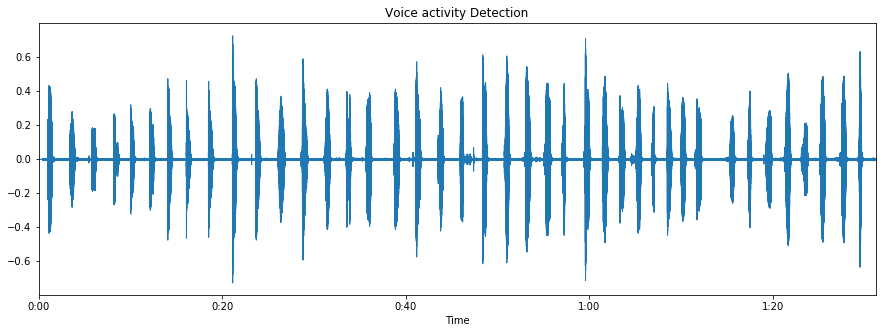

In [21]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(y, sr=sr)
plt.title('Voice activity Detection')

In [22]:
Frame_size = int(np.ceil(sr*0.01))
Num_of_frames = int(np.ceil(len(y)/Frame_size))
E_pthres=40
F_pthres=185
SF_pthres=5

In [23]:
def frames_r(y,start,end):
    return y[start:end]

In [24]:
def to_frames(y,Num_of_frames,Frame_size):
    data_length = len(y)
    frames=[]
    for i in range(0,data_length,Frame_size):
        l=frames_r(y,i,i+Frame_size)
        frames.append(l)
    return frames   

In [25]:
def shortTermEnergy(frame):
    k= sum( [ abs(x)**2 for x in frame ] ) / len(frame)
    return k
'''def calculate_energy2(frame):

    frame = abs(frame)
    energy = np.sum(np.square(frame, dtype=np.int64), dtype=np.int64)
    energy = math.sqrt(energy / len(frame))
    return energy'''

def sfm(frame):
    a = np.mean(frame)
    g = gmean(frame)
    if a == 0 or g/a <= 0:
        sfm = 0
    else:
        sfm = 10*np.log10(g/a)
    return sfm

def mdf(frame): #most dominant requency
    max_ = np.argmax(frame)
    return frame[max_]

In [26]:
frames = np.asarray(to_frames(y,Num_of_frames,Frame_size))

energy = np.array(np.zeros([Num_of_frames]))
dominating_freq = np.array(np.zeros([Num_of_frames]))
sfm_ = np.array(np.zeros([Num_of_frames]),dtype=int)

for i in range(0,Num_of_frames):
    energy[i] = shortTermEnergy(frames[i])
    fft_ = np.fft.rfft(frames[i])
    dominating_freq[i] = np.abs(mdf(fft_))
    sfm_[i] = np.abs(sfm(fft_))
    
min_e = np.min(energy[10:50])
min_f = np.min(dominating_freq[10:50])
min_sf = np.min(sfm_[10:50])

E_thres = E_pthres*np.log10(min_e)
F_thres = F_pthres
SF_thres = SF_pthres

In [27]:
speech = np.array(np.zeros([Num_of_frames]), dtype=bool)
silence_count = 0

# Deciding if a frame is a speech or silence
for i in range(Num_of_frames):
    counter = 0

    if energy[i] - min_e>= E_thres:
         counter += 1
    if dominating_freq[i] - min_f > F_thres:
         counter += 1
    if sfm_[i] - min_sf >= SF_thres:
        counter += 1

    if counter > 1 and i!= Num_of_frames - 1:
        speech[i] = True
    else:
        speech[i] = False
        silence_count += 1
        min_e = ((min_e*silence_count)+energy[i])/(silence_count + 1)
        E_thres = E_pthres*np.log10(min_e)

In [28]:
last = speech[0]
sequence = 0
start = 0
for i in range(len(speech)):
    if last == speech[i]:
        sequence += 1
    else:
        if last is False and sequence < 10:
            for j in range(start, i):
                speech[j] = True
        elif last is True and sequence < 5:
            for j in range(start, i):
                speech[j] = False
        start = i
        sequence = 0

In [29]:
k=0
new_y=Frame_size*Num_of_frames
speech_=np.array(np.zeros([new_y]), dtype=bool)
for i in range(len(speech)):
    for l in range(Frame_size):
        speech_[k]=speech[i]
        k+=1
        
speech_=speech_[0:len(y)]        

In [30]:

def remove_silence(signal, frame_size, speech):
    
    for i in range(len(speech)):
        if not speech[i]:
            signal[frame_size*i:frame_size*(i+1)] = 0

    #result = signal[np.nonzero(signal)]

    return signal

In [31]:
y_ = remove_silence(y,Frame_size,speech)

Text(0.5, 1.0, 'Voice activity Detection')

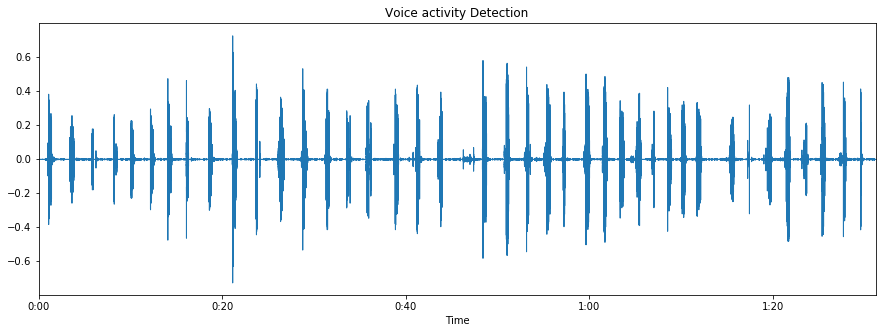

In [32]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(y_, sr=sr)
plt.title('Voice activity Detection')

In [33]:
'''plt.figure(figsize=(15,5))
librosa.display.waveplot(y[speech_], sr=sr)
plt.title('Voice activity Detection')'''

"plt.figure(figsize=(15,5))\nlibrosa.display.waveplot(y[speech_], sr=sr)\nplt.title('Voice activity Detection')"

In [34]:
def p_location(signal):
    start=0
    end=0
    location=[]
    tflag=False
    mask = signal
    for i in range(len(mask)):
        if mask[i] == True :
            if tflag == False :
                tflag = True
                start = i
        else :
            if tflag == True:
                end = i-1
                location.append([start,end,end-start])
                tflag=False
    return np.asarray(location)
    #return (location)

In [35]:
loc=p_location(speech_)

In [36]:
print(loc.shape)
print(loc)

(1150, 3)
[[      0     441     441]
 [    663     883     220]
 [   1105    1767     662]
 ...
 [2000492 2000712     220]
 [2002039 2002259     220]
 [2006017 2006237     220]]


In [37]:
count=0
for f in range(len(loc)):
    j=str(count)
    start = loc[f][0]
    end = loc[f][1]
    diff = loc[f][2]
    if diff > Frame_size :
        i="01-02-01-23-01-"+j+".wav"
        wavfile.write(filename='G:\datasets\phoneme/vad2/'+i,rate=sr,data=y[start:end])
        count+=1

In [38]:
print(count)

236


# Test Section :-

In [39]:
print(min_e ,min_f,min_sf)

0.0015354241154664897 0.00013469876240463242 0


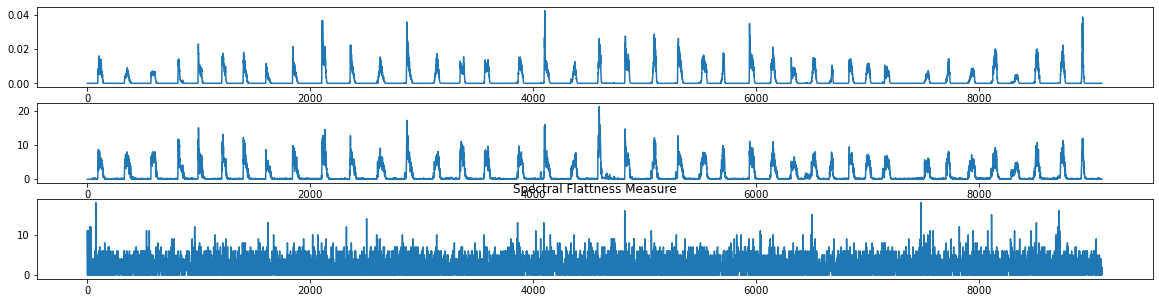

In [40]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot the data
plt.title('Energy')
ax1.plot(energy)
plt.title('Dominating Frequency')
ax2.plot(dominating_freq)
plt.title('Spectral Flattness Measure')
ax3.plot(sfm_)
# Show the plot
plt.show()